In [3]:
%matplotlib inline

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skimage import transform as tf
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

import cv2

from LFWDataset import LFWDataset
from SiameseNet import SiameseNet
# from ContrastiveLoss import ContrastiveLoss
from augmentation import *


In [2]:
%matplotlib inline
def show(img, filename=None, save=False):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()
    
    if save and filename is not None:
        plt.savefig(filename)

def show_plot(iteration,loss, filename='loss.png', save=False):
    plt.plot(iteration,loss)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    if save:
        plt.savefig(filename)

In [4]:
trainset = LFWDataset(train=True,
                      transform=transforms.Compose([augmentation, transforms.Scale((128,128)),
                                                                      transforms.ToTensor()
                                                                      ]))
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)




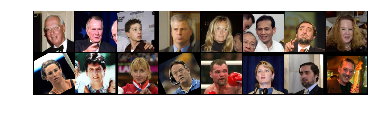

[0 0 0 0 0 0 1 0]


Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/export/home/dli44/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/export/home/dli44/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/export/home/dli44/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/export/home/dli44/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/export/home/dli44/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
  File "/export/home/dli44/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()
  File "/export/home/dli44/anaconda2/lib/python2.7/multiprocessing/que

In [5]:
vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)

show(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [11]:
net = SiameseNet(p1a=True).cuda()
criterion = nn.BCELoss()
learning_rate = 1e-6
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [12]:
# print(net)

In [13]:
counter = []
loss_history = [] 
iteration_number= 0
epochs = 30

In [14]:
for epoch in range(epochs):
    for i, data in enumerate(trainloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output = net(img0, img1)
        label = label.unsqueeze(1).float()

        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.data[0])

Epoch number 0
 Current loss 0.710709035397

Epoch number 0
 Current loss 0.721869826317

Epoch number 0
 Current loss 0.691365122795

Epoch number 0
 Current loss 0.743355035782



Process Process-5:
Process Process-6:
Traceback (most recent call last):
  File "/export/home/dli44/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/export/home/dli44/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/export/home/dli44/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/export/home/dli44/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
  File "/export/home/dli44/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    r = index_queue.get()
    self._target(*self._args, **self._kwargs)
  File "/export/home/dli44/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
  File "/export/home/dli44/anaconda2/lib/python2.7/multiprocessing/queues.py", line 376, in get


KeyboardInterrupt: 

In [ ]:
# show_plot(counter,loss_history, save=True)
plt.figure(figsize=(10, 4))
plt.plot(counter,loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig('loss.png')
plt.show()


In [ ]:
torch.save(net.state_dict(), "p1b")

In [ ]:
testset = LFWDataset(test=True,
                     transform=transforms.Compose([transforms.Scale((128, 128)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
net.load_state_dict(torch.load('p1b'))

In [ ]:
right=wrong=0.

for i, data in enumerate(testloader,0):
    img0, img1, label = data    
    img0, img1, label = Variable(img0).cuda(), Variable(img1).cuda(), Variable(label).cuda()
    
    output1, output2 = net(img0,img1)
    dist = F.pairwise_distance(output1, output2)
    print(dist)
    print(label)
    for x,y in zip(dist, label):
        if (x.data[0]>=11 and y.data[0]==1) or (x.data[0]<11 and y.data[0]==0):
            right+=1
        else:
            wrong+=1
    

In [ ]:
#     print(right, wrong)
testacc = right/(right+wrong)
print("Accuracy on test set: {:.2f}".format(testacc))

In [ ]:
right=wrong=0.

for i, data in enumerate(trainloader,0):
    img0, img1, label = data    
    img0, img1, label = Variable(img0).cuda(), Variable(img1).cuda(), Variable(label).cuda()
    
    output = net(img0,img1)
    for x,y in zip(dist, label):
        if (x.data[0]<=11 and y.data[0]==1) or (x.data[0]>11 and y.data[0]==0):
            right+=1
        else:
            wrong+=1
            

In [ ]:
#     print(right, wrong)
trainacc = right/(right+wrong)
print("Accuracy on train set: {:.2f}".format(trainacc))

In [ ]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.autograd.Variable(torch.randn(3), requires_grad=True)
target = torch.autograd.Variable(torch.FloatTensor(3).random_(2))
print(input, target)
output = loss(m(input), target)
output.backward()

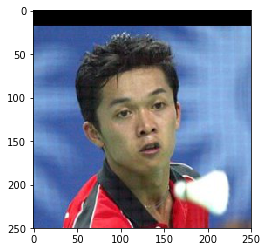

In [4]:
from PIL import Image
im = Image.open("lfw/Taufik_Hidayat/Taufik_Hidayat_0001.jpg")

plt.imshow(im)

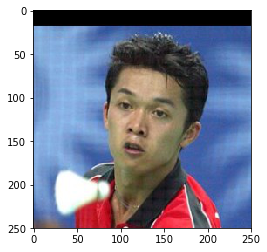

In [7]:
plt.imshow(Image.fromarray(np.fliplr(np.array(im))))

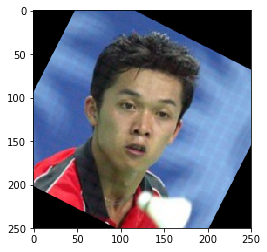

In [8]:
plt.imshow(Image.fromarray((255* tf.rotate(np.array(im), np.random.randint(-30, 31), mode='constant')).astype('uint8')))